In [205]:
from pathlib import Path
from tqdm import tqdm
import os
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [206]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_train = transforms.Compose([
    transforms.ToTensor(),
])
# train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
train_set.data = train_set.data[0: 1000]
train_set.targets = train_set.targets[0: 1000]

In [207]:
BATCH_SIZE = 1000
trainloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

num_classes = 10

In [208]:
d = 784
# d = 32 * 32 * 3
width = 200
kappa = 0.000001
lr = 0.01
EPOCH = 35

In [209]:
def ber_(m, n, k=2., b=-1.):
    x = (k * np.random.randint(0, 2, size=(m*n)) + b).reshape(m, n)
    y = torch.from_numpy(x).float()
    return torch.nn.Parameter(y)

def logistic_loss(by_pre, by):
    v = torch.sum(torch.mul(by_pre, by), dim=1)
    loss_vec = torch.log(1 + torch.exp(- v))
    loss = loss_vec.mean()
    return loss

class FNN(nn.Module):
    def __init__(self, d, width, kappa):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(d, width, bias=True)
        nn.init.normal_(self.fc1.weight, mean=0, std=kappa)
        nn.init.constant_(self.fc1.bias, kappa)
        self.fc2 = nn.Linear(width, num_classes, bias=False)
        self.fc2.weight = ber_(self.fc2.weight.shape[0], self.fc2.weight.shape[1], 2., -1)

    def forward(self, x):
#         x = x.view(-1, 784)
        o = self.fc1(x)
        o = torch.relu(o)
        o = self.fc2(o)
        return o.squeeze()

In [210]:

net_SGD = FNN(d, width, kappa)
opt_SGD = optim.SGD(net_SGD.parameters(), lr=lr)

train_loss = []
criterion = nn.CrossEntropyLoss()

def train_epoch(net, optimizer):
    net.train()
    sum_loss = 0.0
    batch = 0
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        inputs = inputs.view(-1, 784)
#         inputs = inputs.view(-1, 3072)
        inputs = F.normalize(inputs, p=2, dim=1)
        optimizer.zero_grad()
        outputs = net(inputs)
        ouputs = outputs.float()
        ids = torch.LongTensor(labels).view(-1, 1)
        labels = torch.FloatTensor(len(labels), num_classes).zero_().scatter_(1, ids, 1)
        labels = labels.to(device)
        loss = logistic_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()
        batch += 1
    tr_loss = sum_loss / batch
    return tr_loss


In [211]:
for epoch in tqdm(range(EPOCH)):
    tr_loss = train_epoch(net_SGD, opt_SGD)
    train_loss.append(tr_loss)

print("Training Finished!")

100%|██████████| 35/35 [00:01<00:00, 20.69it/s]

Training Finished!


No handles with labels found to put in legend.


Text(0,0.5,'log(loss)')

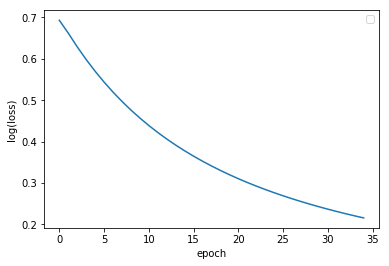

In [212]:
x = range(len(train_loss))
plt.plot(x, train_loss, color='C0')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('log(loss)')
# plt.savefig(save_path / 'train loss.png')

In [213]:
train_loss[0] - train_loss[34]

0.4774114042520523